In [1]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("whitegrid")

In [2]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [3]:

x0 = 1
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, b, f0= 1 , 1, 1, 0



In [4]:
dt = 1/884000
tf = 0.1


N = int(tf / dt)
print(f'N = {N}')
ts = np.arange(0, N + 1) * dt
Xs = np.zeros((N + 1, 2))
Xs[0] = X0

N = 88400


### Primero caracterizamos el tiempo de respuesta del sistema

In [5]:
N_t = int(N/5)
ts = np.arange(0, N_t + 1) * dt
Xs = np.zeros((N_t + 1, 2))
Xs[0] = X0
print(N_t)

17680


In [6]:
#armo el delta

delta = np.ones(N_t+1)
delta[:int(N_t/2)] = 0

In [7]:
Xs = np.zeros((N_t + 1, 2))
Xs[0] = X0

# Integración
for j in range(N_t):
    params = [k, c, delta[j], b]
    Xs[j + 1] = paso_RK(Xs[j], f, ts[j], dt, params, 4)


Tiempo de estabilización ~ 0.004255656108597286s


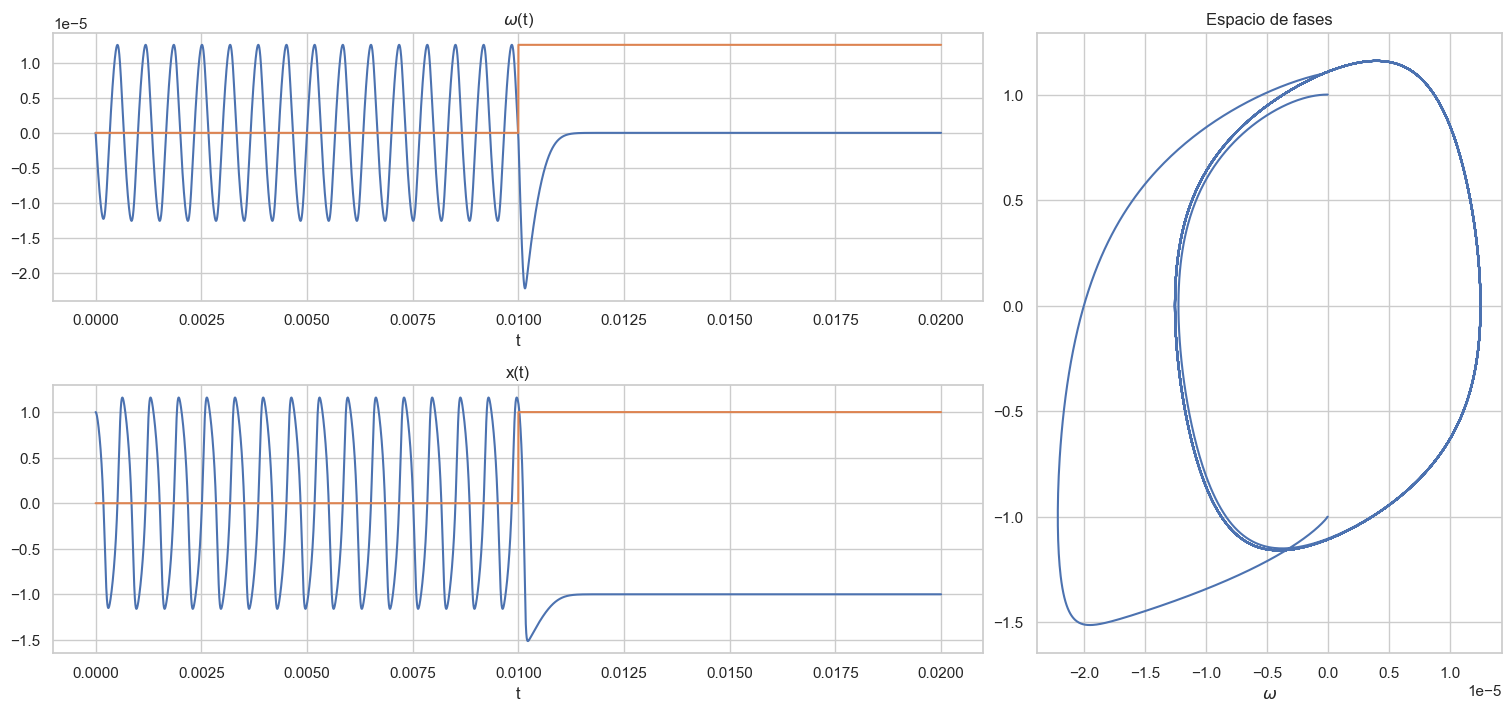

In [8]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (15,7),layout="constrained")
gs = GridSpec(2, 3, figure=fig)


ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[:, -1])

colors = ['green','red','black',"blue"]

#ploteo
ax1.plot(ts,Xs[:,0])
ax1.plot(ts,delta*max(Xs[:,0]), label = r'$\delta$')

ax2.plot(ts,Xs[:,1])
ax2.plot(ts,delta, label = r'$\delta$')

ax3.plot(Xs[:,0],Xs[:,1])


ax2.set_title('x(t)')
ax1.set_title(r'$\omega$(t)')
ax3.set_title('Espacio de fases')
ax1.set_xlabel('t')
ax2.set_xlabel('t')
ax3.set_xlabel(r'$\omega$')

#tiempo que tarda en estabilizarse: 
t_i = ts[int(N_t/2)]
#tiempo en el que omega es nulo (~1e-19)
t_segunda_mitad = ts[int(N_t/2):]
t_nulo = t_segunda_mitad[np.abs(Xs[:,0][int(N_t/2):])<1e-19]
t_f = t_nulo[0]
t_e = t_f-t_i
print(f'Tiempo de estabilización ~ {t_e}s')


### Veo cómo responde el sistema para distintos valores de $\delta$

In [9]:
dt = 1/884000
tf = 0.2


N = int(tf / dt)
print(f'N = {N}')
ts = np.arange(0, N + 1) * dt
Xs = np.zeros((N + 1, 2))
Xs[0] = X0

N = 176800


In [10]:
#armo el delta
delta = np.ones(N+1)
n_deltas = int(tf/(t_e*4))
split_deltas = np.array_split(delta, n_deltas)

for i,n in enumerate(np.linspace(0,1, n_deltas)):
    split_deltas[i] = split_deltas[i] * n
deltas = np.concatenate(split_deltas, axis=0)

In [11]:
Xs = np.zeros((N + 1, 2))
Xs[0] = X0

# Integración
for j in range(N):
    params = [k, c, deltas[j], b]
    Xs[j + 1] = paso_RK(Xs[j], f, ts[j], dt, params, 4)


Text(0.5, 0, '$\\omega$')

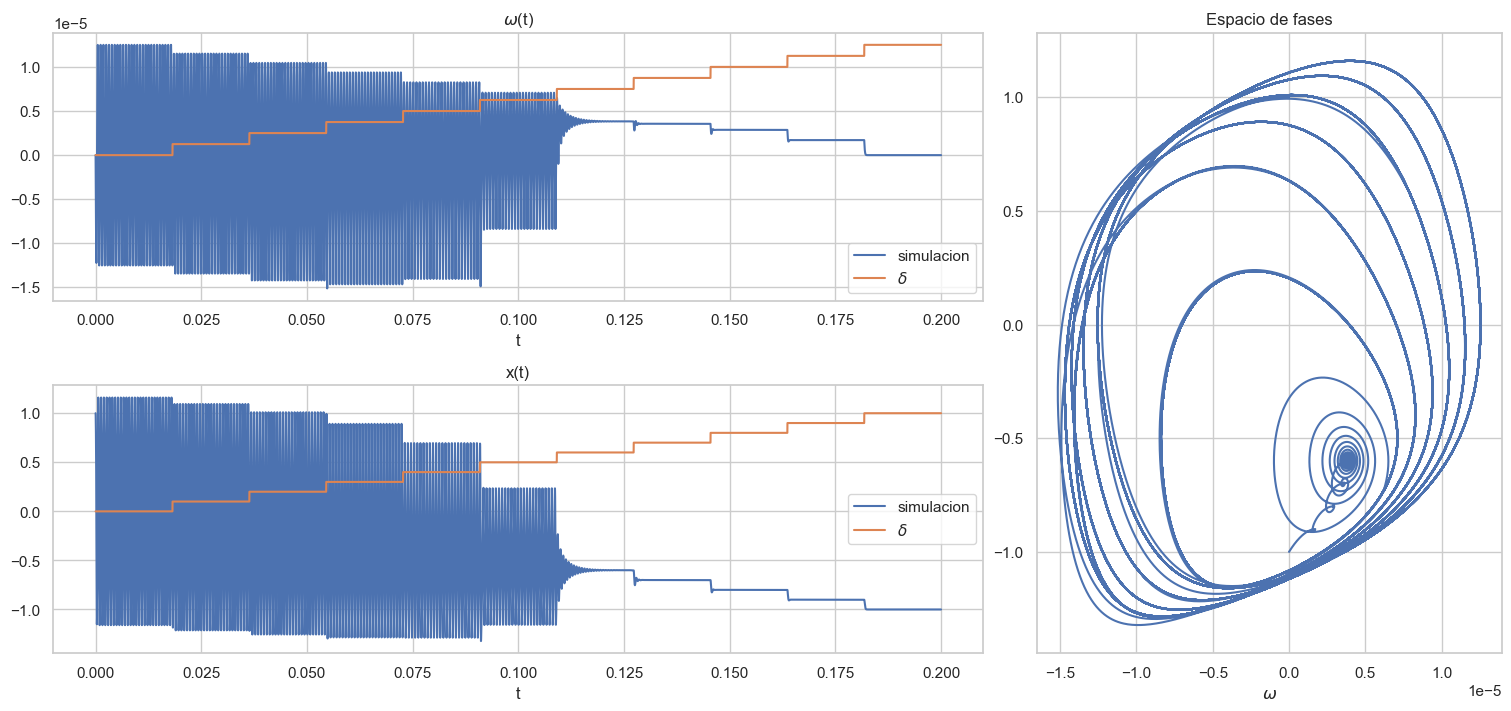

In [12]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (15,7),layout="constrained")
gs = GridSpec(2, 3, figure=fig)


ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[:, -1])

colors = ['green','red','black',"blue"]

#ploteo
ax1.plot(ts,Xs[:,0], label = 'simulacion')
ax1.plot(ts,deltas*max(Xs[:,0]), label = r'$\delta$')
ax1.legend()

ax2.plot(ts,Xs[:,1], label = 'simulacion')
ax2.plot(ts,deltas, label = r'$\delta$')
ax2.legend()

ax3.plot(Xs[:,0],Xs[:,1])


ax2.set_title('x(t)')
ax1.set_title(r'$\omega$(t)')
ax3.set_title('Espacio de fases')
ax1.set_xlabel('t')
ax2.set_xlabel('t')
ax3.set_xlabel(r'$\omega$')




In [13]:
# valor donde hay fonacion y se disipa
#armo otro delta

delta = np.ones(N+1)
n_deltas = int(tf/(t_e*5.5))
split_deltas = np.array_split(delta, n_deltas)

for i,n in enumerate(np.linspace(0.5,0.7, n_deltas)):
    split_deltas[i] = split_deltas[i] * n
deltas = np.concatenate(split_deltas, axis=0)


In [14]:
Xs = np.zeros((N + 1, 2))
Xs[0] = X0

# Integración
for j in range(N):
    params = [k, c, deltas[j], b]
    Xs[j + 1] = paso_RK(Xs[j], f, ts[j], dt, params, 4)


Text(0.5, 0, '$\\omega$')

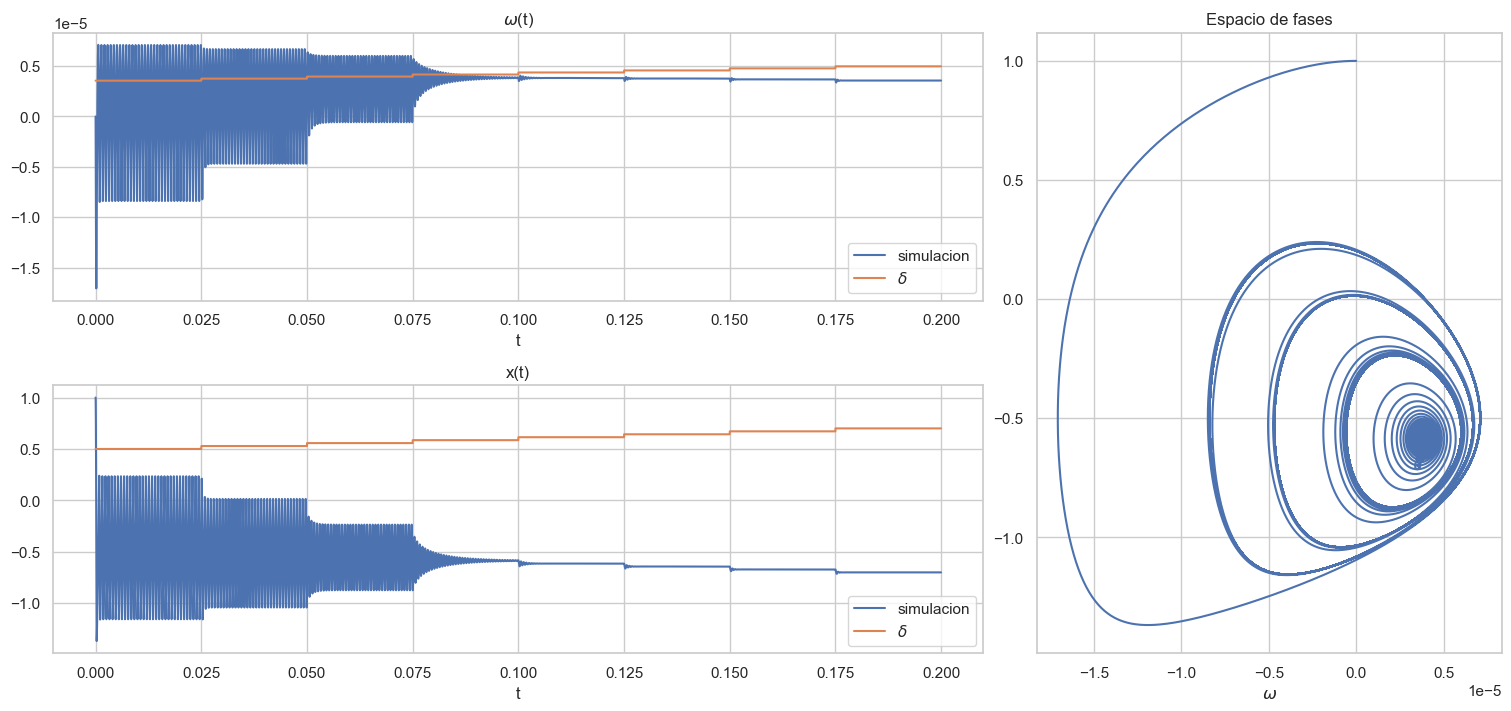

In [15]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (15,7),layout="constrained")
gs = GridSpec(2, 3, figure=fig)


ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[:, -1])

colors = ['green','red','black',"blue"]

#ploteo
ax1.plot(ts,Xs[:,0], label = 'simulacion')
ax1.plot(ts,deltas*max(Xs[:,0]), label = r'$\delta$')
ax1.legend()

ax2.plot(ts,Xs[:,1], label = 'simulacion')
ax2.plot(ts,deltas, label = r'$\delta$')
ax2.legend()

ax3.plot(Xs[:,0],Xs[:,1])


ax2.set_title('x(t)')
ax1.set_title(r'$\omega$(t)')
ax3.set_title('Espacio de fases')
ax1.set_xlabel('t')
ax2.set_xlabel('t')
ax3.set_xlabel(r'$\omega$')




In [16]:
#tf/t_e ~ 23. Tengo que tener como máximo 11
def plot1(escalones, delta_min, delta_max ):
    delta = np.ones(N+1)
    n_deltas = escalones
    split_deltas = np.array_split(delta, n_deltas)
    
    for i,n in enumerate(np.linspace(delta_min,delta_max, n_deltas)):
        split_deltas[i] = split_deltas[i] * n
    deltas = np.concatenate(split_deltas, axis=0)
    
    Xs = np.zeros((N + 1, 2))
    Xs[0] = X0
    
    # Integración
    for j in range(N):
        params = [k, c, deltas[j], b]
        Xs[j + 1] = paso_RK(Xs[j], f, ts[j], dt, params, 4)
    
        
    fig = plt.figure(figsize = (15,7),layout="constrained")
    gs = GridSpec(2, 3, figure=fig)
    
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[:, -1])
    
    colors = ['green','red','black',"blue"]
    
    #ploteo
    ax1.plot(ts,Xs[:,0], label = 'simulacion')
    ax1.plot(ts,deltas*max(Xs[:,0]), label = r'$\delta$')
    ax1.legend()
    
    ax2.plot(ts,Xs[:,1], label = 'simulacion')
    ax2.plot(ts,deltas, label = r'$\delta$')
    ax2.legend()
    
    ax3.plot(Xs[:,0],Xs[:,1])
    
    
    ax2.set_title('x(t)')
    ax1.set_title(r'$\omega$(t)')
    ax3.set_title('Espacio de fases')
    ax1.set_xlabel('t')
    ax2.set_xlabel('t')
    ax3.set_xlabel(r'$\omega$')

    plt.show()

#params
escalones = widgets.IntSlider(value=6 , min= 1 , max= 11, step= 1, description='escalones')
delta_min = widgets.FloatSlider(value=0 , min= 0 , max= 2, step= 1e-4, description='delta_min')
delta_max = widgets.FloatSlider(value=1 , min= 0 , max= 2, step= 1e-4, description='delta_max')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'escalones': escalones, 'delta_min': delta_min, 'delta_max': delta_max})

# muestro los outputs#
display(escalones, delta_min, delta_max, output1)
#probar d_min 0.56, d_max 0.6

IntSlider(value=6, description='escalones', max=11, min=1)

FloatSlider(value=0.0, description='delta_min', max=2.0, step=0.0001)

FloatSlider(value=1.0, description='delta_max', max=2.0, step=0.0001)

Output()

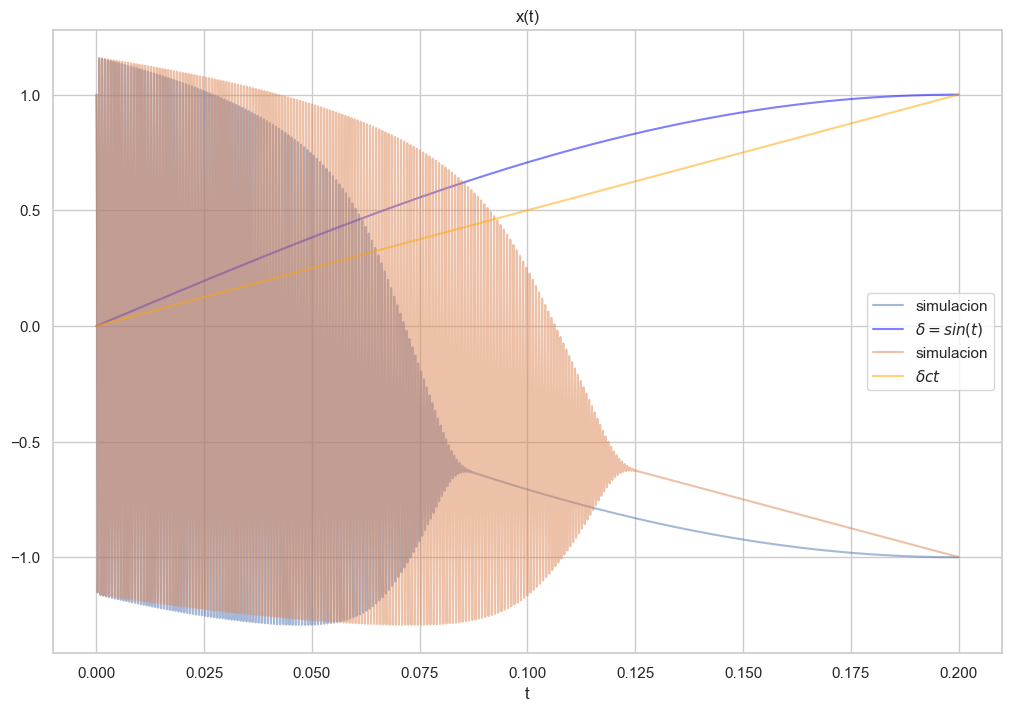

In [34]:

Xs1 = np.zeros((N + 1, 2))
Xs1[0] = X0

Xs2 = np.zeros((N + 1, 2))
Xs2[0] = X0

deltas =[np.sin(ts*np.pi*2.5) , ts*5]

# Integración
for j in range(N):
    params1 = [k, c, deltas[0][j], b]
    params2 = [k, c, deltas[1][j], b]
    Xs1[j + 1] = paso_RK(Xs1[j], f, ts[j], dt, params1, 4)
    Xs2[j + 1] = paso_RK(Xs2[j], f, ts[j], dt, params2, 4)

    
fig = plt.figure(figsize = (10,7),layout="constrained")

plt.plot(ts,Xs1[:,1], alpha = 0.5, label = 'simulacion')
plt.plot(ts,deltas[0], alpha = .5,  label = r'$\delta = sin(t)$', color = 'blue')
plt.plot(ts,Xs2[:,1], alpha = 0.5,  label = 'simulacion')
plt.plot(ts,deltas[1], alpha = .5, label = r'$\delta c t$', color = 'orange')
plt.legend()
plt.title('x(t)')
plt.xlabel('t')

plt.show()
